# Reflected scattered wave LIPSS

### Calculates the predicted period and orientation of laser induced periodic surface structures formed from surface scattered waves that have reflected off the boundary of the laser damage spot. This is depicted in the figure below where the top half of a damage spot is shown. Here $k_s$, $k_{sr}$, $k_{\parallel}$, and $G$ represent the wavevectors of the surface scattered wave, the reflected surface scattered wave, the incident laser light, and the induced grating, respectively. 

<img src="Reflected_Surface-scattered-wave.svg" >

In [1]:
#Imports
from math import *
import cmath
import numpy as np
import scipy as sp
import scipy.special
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

#Import custom modules
from physics import *

sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_palette(palette='deep')
sns.set_color_codes(palette='deep')

%matplotlib notebook

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Calculate period for every possible reflecting plane angle and scattered wave angle pair
For a given reflecting plane angle $\theta$, interference can only occur for scattered wave angles $\phi$ satisfying $\theta-\pi/2 < \phi < \theta+\pi/2$

In [2]:
def GratingVector(kparallel_x,kparallel_y,ks_x,ks_y,ksr_x,ksr_y):
    """Returns the components of the grating vector given the component of the laser wavevector parallel to
    the surface, the scattered wave wavevector, and the reflected scattered wave wavevector. Each possible
    interference case is calculated."""
    
    #Case 1
    G1_x = kparallel_x - ks_x
    G1_y = kparallel_y - ks_y
    
    #Case 2:
    G2_x = kparallel_x - ksr_x
    G2_y = kparallel_y - ksr_y
    
    #Case 3:
    G3_x = ks_x - ksr_x
    G3_y = ks_y - ksr_y
    
    #Case 4:
    G4_x = ks_x + ksr_x - kparallel_x
    G4_y = ks_y + ksr_y - kparallel_y

    #Case 5:
    G5_x = ks_x + kparallel_x - ksr_x
    G5_y = ks_y + kparallel_y - ksr_y

    #Case 6:
    G6_x = ksr_x + kparallel_x - ks_x
    G6_y = ksr_y + kparallel_y - ks_y
    
    return np.array([[G1_x,G1_y],[G2_x,G2_y],[G3_x,G3_y],[G4_x,G4_y],[G5_x,G5_y],[G6_x,G6_y]])

def arctan3(x1,x2):
    """Returns the arctangent of x1/x2, choosing the correct quadrant as numpy's arctan2 function does. However,
    here we consider an angle theta to be equivalent to theta + pi. In other words, we're taking a vector v and
    an antiparallel vector -v to be pointing in the same direction. As a result, this function will only return 
    values between 0 and pi.
    
    For example, the vector (1,1) would have an arctangent of pi/4. The vector (-1,-1) is pointing antiparallel 
    to (1,1) but is essentially the same direction for our purposes, so it's arctangent is also evaluated to 
    be pi/4 by this function. In contrast, numpy.arctan2 would evaluate it to be -3pi/4."""
    
    arctangent = np.arctan2(x1,x2)
    
    arctangent[arctangent<0] = pi + arctangent[arctangent<0]
    
    return arctangent

def GratingVectorPolar(kparallel_x,kparallel_y,ks_x,ks_y,ksr_x,ksr_y):
    G = GratingVector(kparallel_x,kparallel_y,ks_x,ks_y,ksr_x,ksr_y)
    Gmag = np.zeros((6,) + np.shape(G)[2:]) #The magnitude doesn't have x and y components but is otherwise the same shape
    Gangle = np.zeros((6,) + np.shape(G)[2:]) #Same for the angle
    for i in range(6): #Loop over all 6 cases
        Gmag[i] = np.sqrt(G[i,0,:,:]**2 + G[i,1,:,:]**2)
        Gangle[i] = arctan3(G[i,1,:,:],G[i,0,:,:])
        
    return Gmag,Gangle

In [3]:
#All wavevectors have had the factor of 2pi divided out

wavelength = 1
Angle_of_incidence = pi/4 #Angle of incidence for the laser pulse
n = 4 #Refractive index

Num_Angles = 1000
theta = np.linspace(0,2*pi,Num_Angles).reshape((Num_Angles,1))
halfpi_array = pi/2*np.linspace(-1,1,Num_Angles)
phi = theta + halfpi_array
phi_reflected = theta - phi

#Laser wave vector (component parallel to surface)
kparallel_x = 1/wavelength*sin(Angle_of_incidence)
kparallel_y = 0

#x and y components of scattered wave vector
ks_x = n/wavelength*np.cos(phi)
ks_y = n/wavelength*np.sin(phi)

#x an y components of reflected wave vector
ksr_x = n/wavelength*np.cos(2*theta - phi - pi)
ksr_y = n/wavelength*np.sin(2*theta - phi - pi)

#LIPSS grating vector
G_Polar = GratingVectorPolar(kparallel_x,kparallel_y,ks_x,ks_y,ksr_x,ksr_y)
Period = 1/G_Polar[0]
G_Angle = G_Polar[1]

## Plot period as a function of reflecting plane angle and scattered wave angle of incidence

<IPython.core.display.Javascript object>


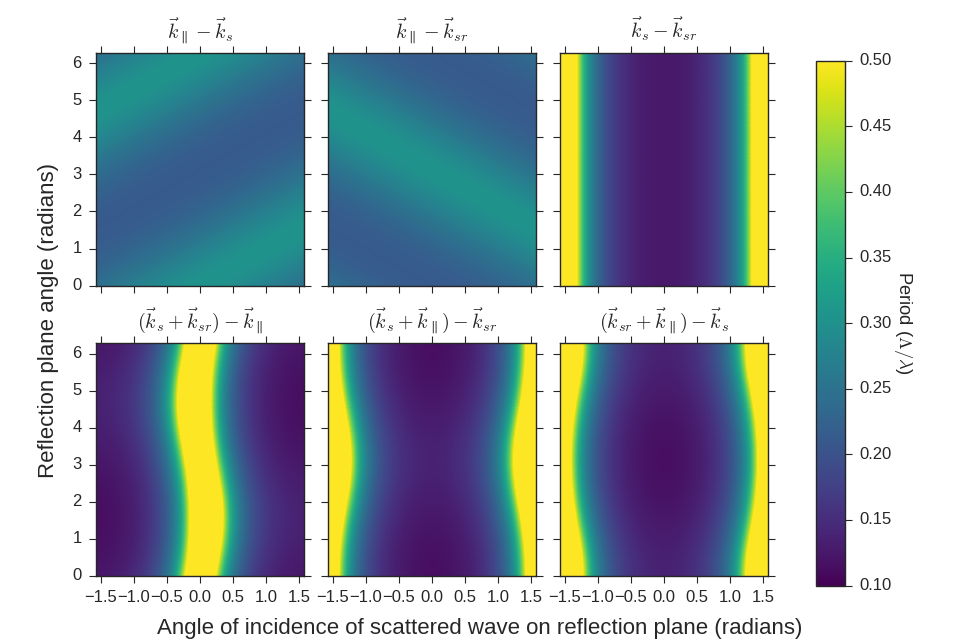

In [4]:
fig,ax = plt.subplots(2,3,sharex=True,sharey=True,figsize=(12, 8))

CaseLabels = ['$\\vec{k}_{\parallel} - \\vec{k}_{s}$','$\\vec{k}_{\parallel} - \\vec{k}_{sr}$',\
              '$\\vec{k}_s - \\vec{k}_{sr}$', '$(\\vec{k}_s + \\vec{k}_{sr}) - \\vec{k}_{\parallel}$',\
             '$(\\vec{k}_{s} + \\vec{k}_{\parallel}) - \\vec{k}_{sr}$',\
              '$(\\vec{k}_{sr} + \\vec{k}_{\parallel}) - \\vec{k}_s$']

for i in range(6):
    #Find corresponding row and column indices from plot number
    rowindex = i//3
    colindex = i-3*(i//3)
    
    PeriodPlot = ax[rowindex,colindex].pcolormesh(phi_reflected,theta,Period[i],cmap='viridis',\
                                                  vmin=0.1,vmax=0.5)
    ax[rowindex,colindex].set_xlim(-pi/2,pi/2)
    ax[rowindex,colindex].set_ylim(np.min(theta),np.max(theta))
    ax[rowindex,colindex].set_title(CaseLabels[i],y=1.04)

fig.text(0.5, 0.01, 'Angle of incidence of scattered wave on reflection plane (radians)', ha='center',fontsize=20)
fig.text(0.04, 0.5, 'Reflection plane angle (radians)', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()
fig.subplots_adjust(left=0.1,right=0.8,bottom=0.1)
cbar_ax = fig.add_axes([0.85, 0.085, 0.03, 0.82])
cbar = fig.colorbar(PeriodPlot, cax=cbar_ax)
cbar.set_label('Period ($\Lambda / \lambda$)', rotation=270, labelpad=20)

<IPython.core.display.Javascript object>


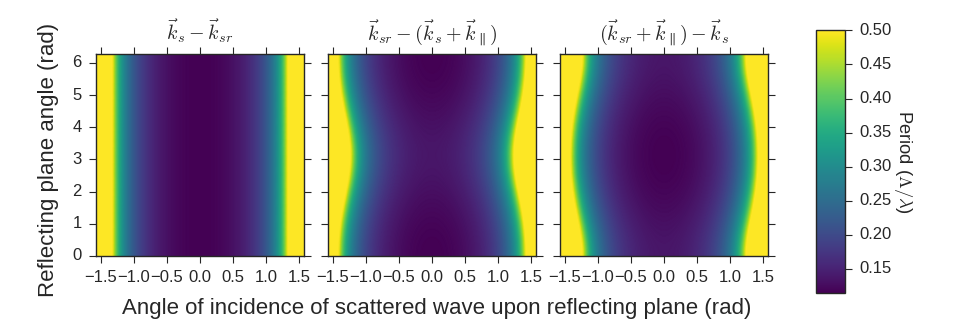

In [6]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12, 4))

CaseLabels = ['$\\vec{k}_{\parallel} - \\vec{k}_{s}$','$\\vec{k}_{\parallel} - \\vec{k}_{sr}$',\
              '$\\vec{k}_s - \\vec{k}_{sr}$', '$(\\vec{k}_s + \\vec{k}_{sr}) - \\vec{k}_{\parallel}$',\
             '$\\vec{k}_{sr} - (\\vec{k}_{s} + \\vec{k}_{\parallel})$',\
              '$(\\vec{k}_{sr} + \\vec{k}_{\parallel}) - \\vec{k}_s$']
    
PeriodPlot = ax[0].pcolormesh(phi_reflected,theta,Period[2],cmap='viridis',\
                                              vmin=np.min(Period[2]),vmax=0.5,shading='gouraud')
ax[0].set_xlim(-pi/2,pi/2)
ax[0].set_ylim(np.min(theta),np.max(theta))
ax[0].set_title(CaseLabels[2],y=1.04)

PeriodPlot = ax[1].pcolormesh(phi_reflected,theta,Period[4],cmap='viridis',\
                                              vmin=np.min(Period[4]),vmax=0.5,shading='gouraud')
ax[1].set_xlim(-pi/2,pi/2)
ax[1].set_ylim(np.min(theta),np.max(theta))
ax[1].set_title(CaseLabels[4],y=1.04)

PeriodPlot = ax[2].pcolormesh(phi_reflected,theta,Period[5],cmap='viridis',\
                                              vmin=np.min(Period[5]),vmax=0.5,shading='gouraud')
ax[2].set_xlim(-pi/2,pi/2)
ax[2].set_ylim(np.min(theta),np.max(theta))
ax[2].set_title(CaseLabels[5],y=1.04)

fig.text(0.455, 0.02, 'Angle of incidence of scattered wave upon reflecting plane (rad)', ha='center',fontsize=20)
fig.text(0.04, 0.5, 'Reflecting plane angle (rad)', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()
fig.subplots_adjust(left=0.1,right=0.8,bottom=0.2)
cbar_ax = fig.add_axes([0.85, 0.085, 0.03, 0.82])
cbar = fig.colorbar(PeriodPlot, cax=cbar_ax)
cbar.set_label('Period ($\Lambda / \lambda$)', rotation=270, labelpad=20)
plt.savefig('Reflected_scattered_wave_period.png',dpi=120)

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


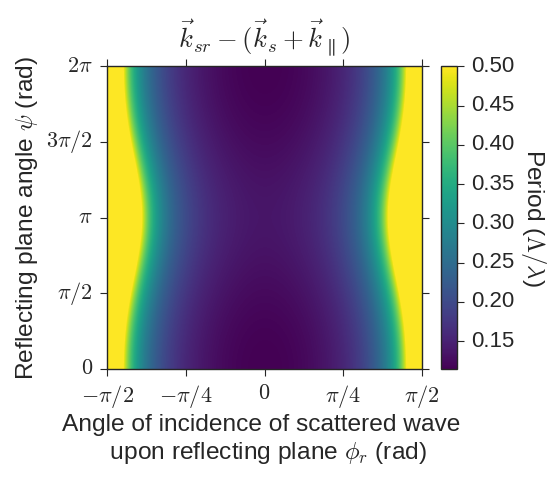

In [7]:
CaseLabels[4] = '$\\vec{k}_{sr} - (\\vec{k}_{s} + \\vec{k}_{\parallel})$'

sns.set(font_scale=2.0)
sns.set_style("ticks")
sns.set_palette(palette='deep')
sns.set_color_codes(palette='deep')

fig,ax = plt.subplots(figsize=(7, 6))
img = ax.imshow(Period[4],cmap='viridis',vmin=np.min(Period[4]), vmax=0.5, extent=[-pi/2,pi/2,0,2*pi],aspect='auto')
ax.set_title(CaseLabels[4],y=1.04)

ax.set_xlim((-pi/2, pi/2))
ax.set_xticks([-pi/2, -pi/4, 0, pi/4, pi/2])
ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '$0$', '$\pi/4$', '$\pi/2$'])
ax.set_xlabel('Angle of incidence of scattered wave \n upon reflecting plane $\phi_r$ (rad)')

ax.set_ylim((0, 2*pi))
ax.set_yticks([0, pi/2, pi, 3*pi/2, 2*pi])
ax.set_yticklabels(['$0$', '$\pi/2$', '$\pi$', '$3 \pi/2$', '$2 \pi$'])
ax.set_ylabel('Reflecting plane angle $\psi$ (rad)')

cbar = fig.colorbar(img)
cbar.set_label('Period ($\Lambda / \lambda$)', rotation=270, labelpad=30)

plt.tight_layout()
#plt.savefig('Reflected_scattered_wave_period.png',dpi=360)
plt.savefig('Reflected_scattered_wave_period.svg')

## Plot grating angle as a function of reflecting plane angle and scattered wave angle of incidence

<IPython.core.display.Javascript object>


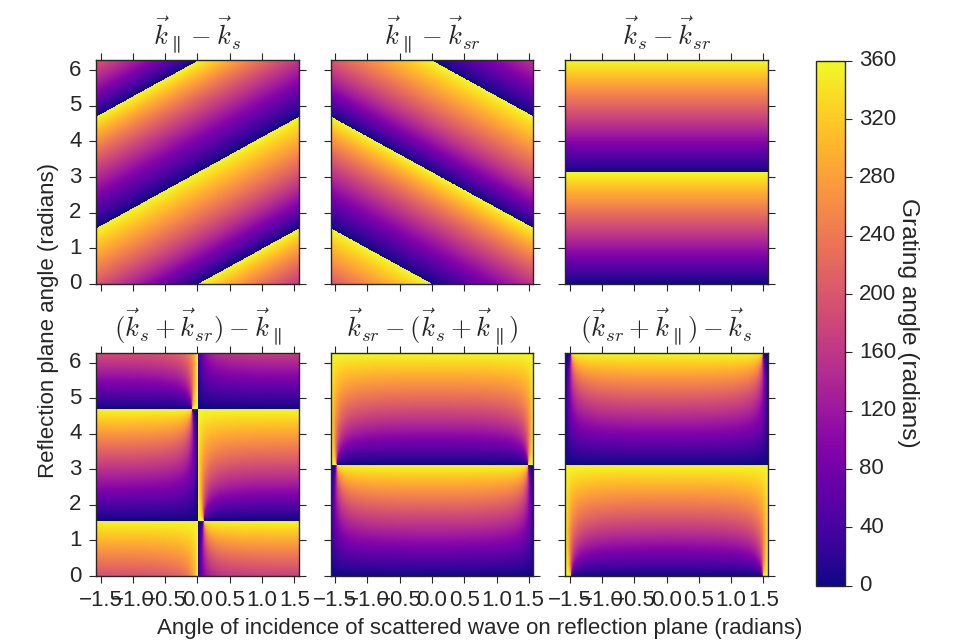

In [10]:
fig,ax = plt.subplots(2,3,sharex=True,sharey=True,figsize=(12, 8))

HUSL = cmap1 = mpl.colors.ListedColormap(sns.color_palette("husl", 256))
HLS = cmap1 = mpl.colors.ListedColormap(sns.color_palette("hls", 256))
for i in range(6):
    #Find corresponding row and column indices from plot number
    rowindex = i//3
    colindex = i-3*(i//3)
    
    PeriodPlot = ax[rowindex,colindex].pcolormesh(phi_reflected,theta,2*G_Angle[i]*180/pi,cmap='plasma',vmin=0,vmax=360)
    ax[rowindex,colindex].set_xlim(-pi/2,pi/2)
    ax[rowindex,colindex].set_ylim(np.min(theta),np.max(theta))
    ax[rowindex,colindex].set_title(CaseLabels[i],y=1.04)

fig.text(0.5, 0.01, 'Angle of incidence of scattered wave on reflection plane (radians)', ha='center',fontsize=20)
fig.text(0.04, 0.5, 'Reflection plane angle (radians)', va='center', rotation='vertical',fontsize=20)

plt.tight_layout()
fig.subplots_adjust(left=0.1,right=0.8,bottom=0.1)
cbar_ax = fig.add_axes([0.85, 0.085, 0.03, 0.82])
cbar = fig.colorbar(PeriodPlot, cax=cbar_ax)
cbar.set_label('Grating angle (radians)', rotation=270, labelpad=20)